In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
#Compute sorted pair (i, j), sorted by i^2 + j^2
#wInt64h i≥0 and j≥0 and i+j>0
#These pairs are used for Karhunen–Loève expansion

def compute_seq_pairs(N_KL, include_00 = False):
    trunc_Nx = int(np.floor(np.sqrt(2*N_KL)) + 1)

    seq_pairs = np.zeros(((trunc_Nx+1)**2 - 1 + include_00, 3))

    seq_pairs_i = 0

    for i in range(trunc_Nx):
        for j in range(trunc_Nx):
            if (i == 0 & j ==0 & (not include_00)):
                continue
            seq_pairs[seq_pairs_i, :] = [i, j, i**2 + j**2]
            seq_pairs_i += 1

    seq_pairs = seq_pairs[:N_KL,:]
    seq_pairs = seq_pairs[seq_pairs[:, -1].argsort()] 

    return seq_pairs[:,:-1]

In [16]:
def c_func_random(x1, x2,seq_pairs,tao = 3, d = 2):

    N_KL = seq_pairs.shape[0]
    theta = np.random.normal(0,1,N_KL)

    c = np.zeros_like(x1)

    for i in range(N_KL):

        λ = ((np.pi**2)*(seq_pairs[i, 0]**2 + seq_pairs[i, 1]**2) + tao**2)**(-d)
        
        if ((seq_pairs[i, 0] == 0) & (seq_pairs[i, 1] == 0)):
           c += theta[i] * np.sqrt(λ)
        elif (seq_pairs[i, 0] == 0):
           c += theta[i] * np.sqrt(λ) * np.sqrt(2)*np.cos(np.pi * (seq_pairs[i, 1]*x2))
        elif (seq_pairs[i, 1] == 0):
           c += theta[i] * np.sqrt(λ) * np.sqrt(2)*np.cos(np.pi * (seq_pairs[i, 0]*x1))
        else:
            c += theta[i] * np.sqrt(λ) * 2*np.cos(np.pi * (seq_pairs[i, 0]*x1)) *  np.cos(np.pi * (seq_pairs[i, 1]*x2))
    return c

In [17]:
N_KL = 150
seq_pairs = compute_seq_pairs(N_KL)

N = 100
xgrid = np.linspace(0,1,N+1)
Y, X = np.meshgrid(xgrid, xgrid)

0.1363931783474257 -0.20660235719953152
0.21155865004944013 -0.30771970126150866
0.2431883278916132 -0.15951009392983928


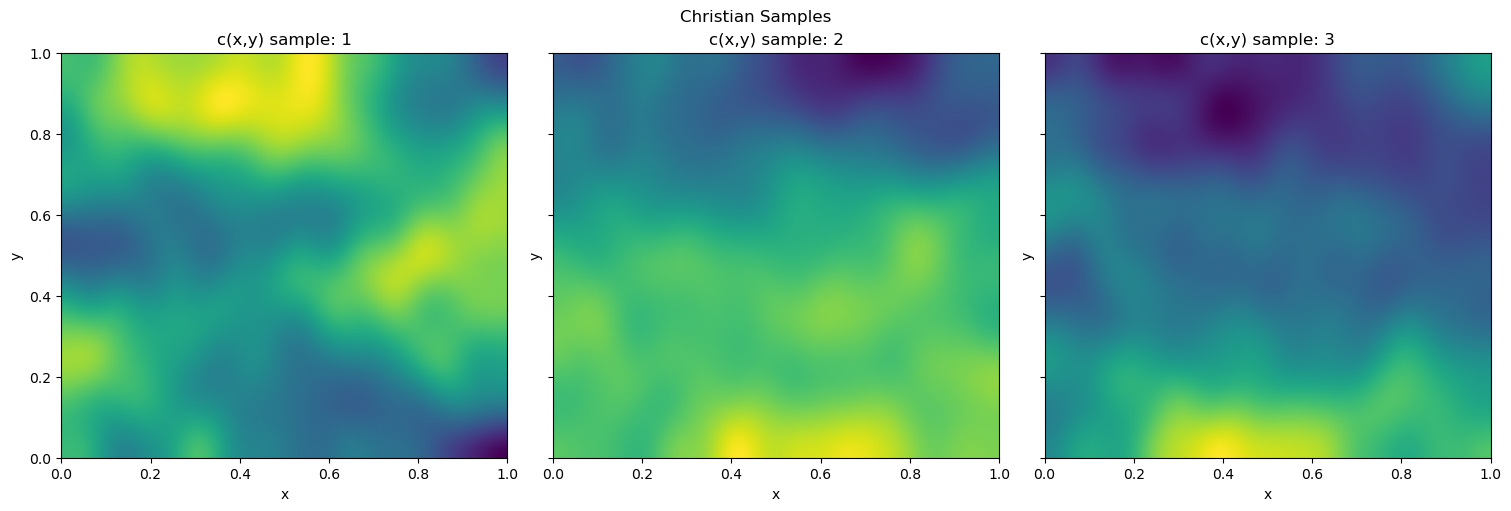

In [18]:
_, axs = plt.subplots(1,3,figsize = (15,5), layout='constrained', sharey=True)
plt.suptitle("Christian Samples")
for i in range(3):
    c = c_func_random(Y,X,seq_pairs)
    print(np.max(c),np.min(c))

    axs[i].pcolormesh(X, Y, c, shading="gouraud")
    axs[i].set_xlabel("x"), axs[i].set_ylabel("y"), axs[i].set_title(f"c(x,y) sample: {i+1}")


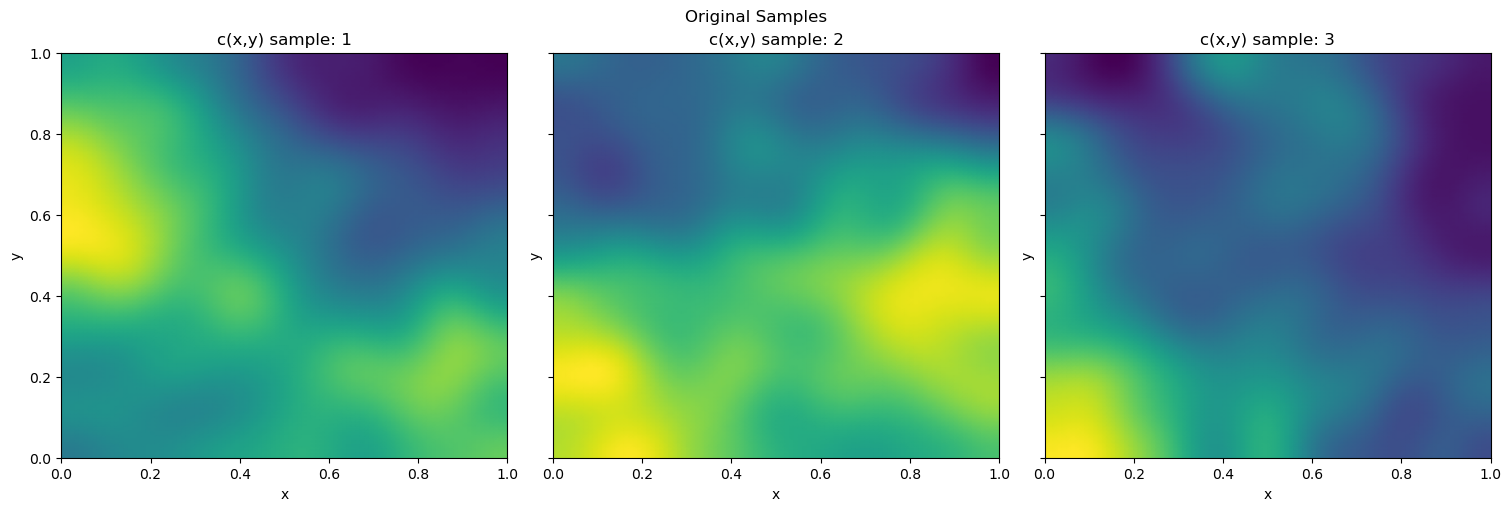

In [19]:
inputs = np.load("../../../../data/Helmholtz_inputs.npy")   
outputs = np.load("../../../../data/Helmholtz_outputs.npy")   

M = 1000
acc = 0.99

_, axs = plt.subplots(1,3,figsize = (15,5), layout='constrained', sharey=True)
plt.suptitle("Original Samples")
for i in range(3):
    axs[i].pcolormesh(X, Y, inputs[:,:,i], shading="gouraud")
    axs[i].set_xlabel("x"), axs[i].set_ylabel("y"), axs[i].set_title(f"c(x,y) sample: {i+1}")


In [20]:
print(inputs.shape)
print(outputs.shape)

(101, 101, 40000)
(101, 101, 40000)


In [23]:
print(np.min(inputs),np.max(inputs))

19.339085895466045 20.606853353634474


In [7]:
train_inputs = np.reshape(inputs[:,:,:M//2], (-1, M//2))
print(train_inputs.shape)

(10201, 500)


In [8]:
Ui,Si,Vi = np.linalg.svd(train_inputs)

In [9]:
print(Ui.shape,Si.shape,Vi.shape)
s = np.concatenate([np.diag(Si), np.zeros((Ui.shape[0]-Si.shape[0], Si.shape[0]))], axis=0)
res = Ui @s@Vi

np.allclose(res, train_inputs)

(10201, 10201) (500,) (500, 500)


True

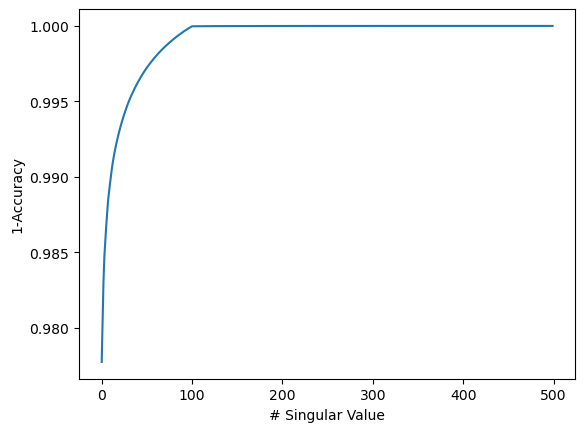

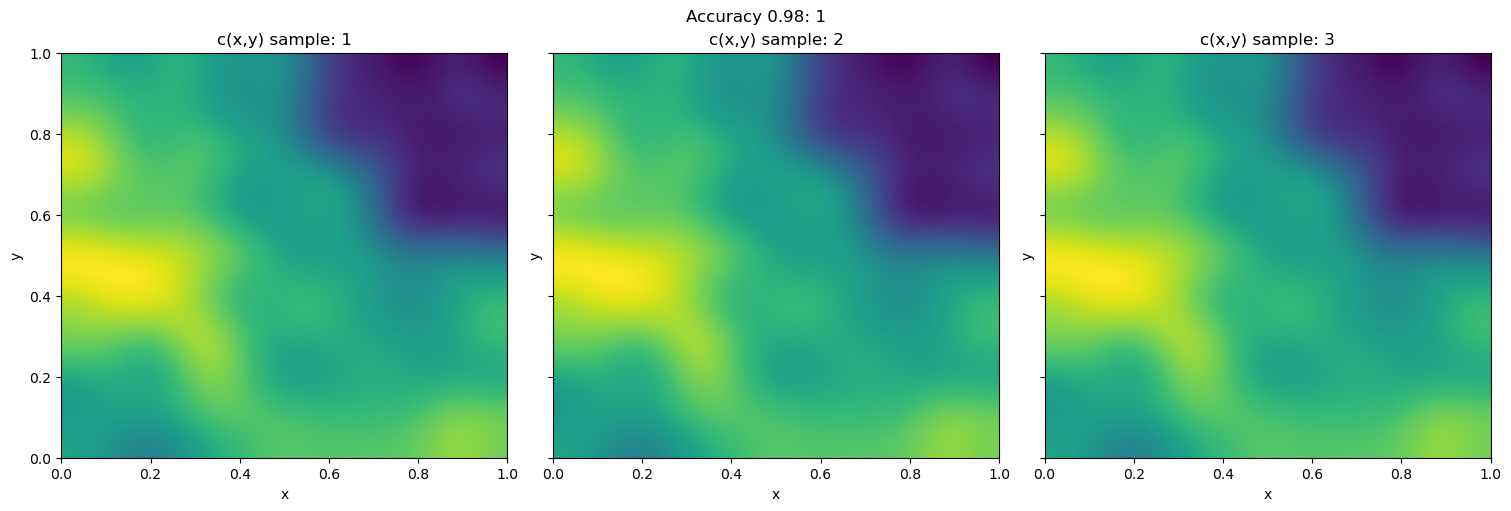

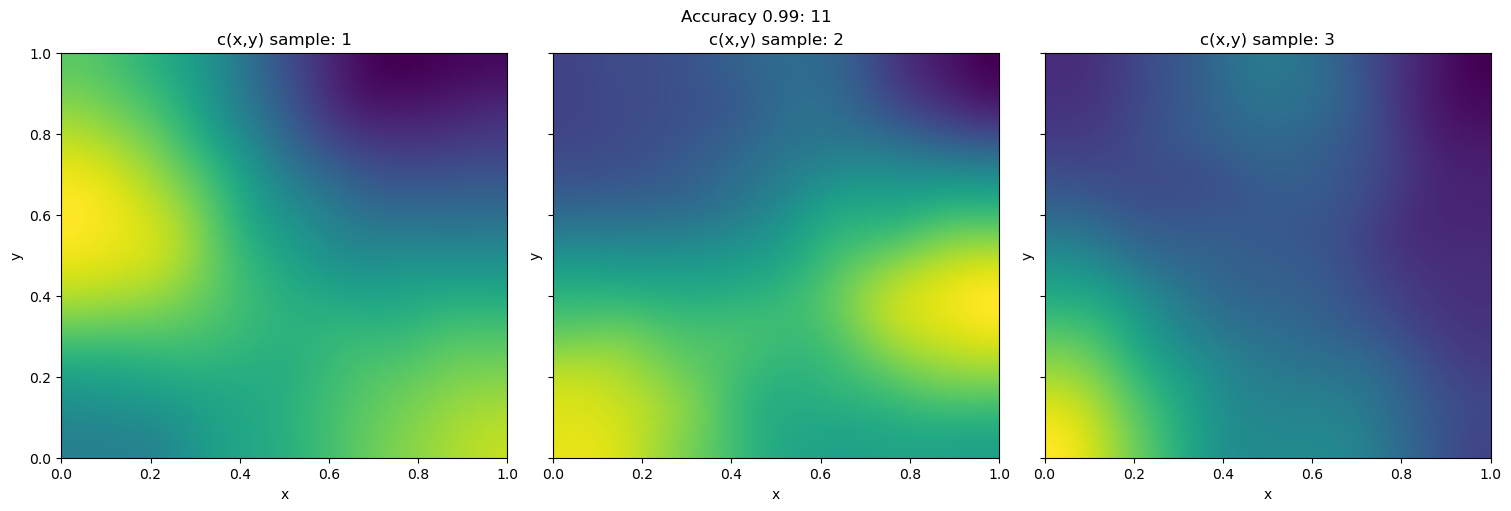

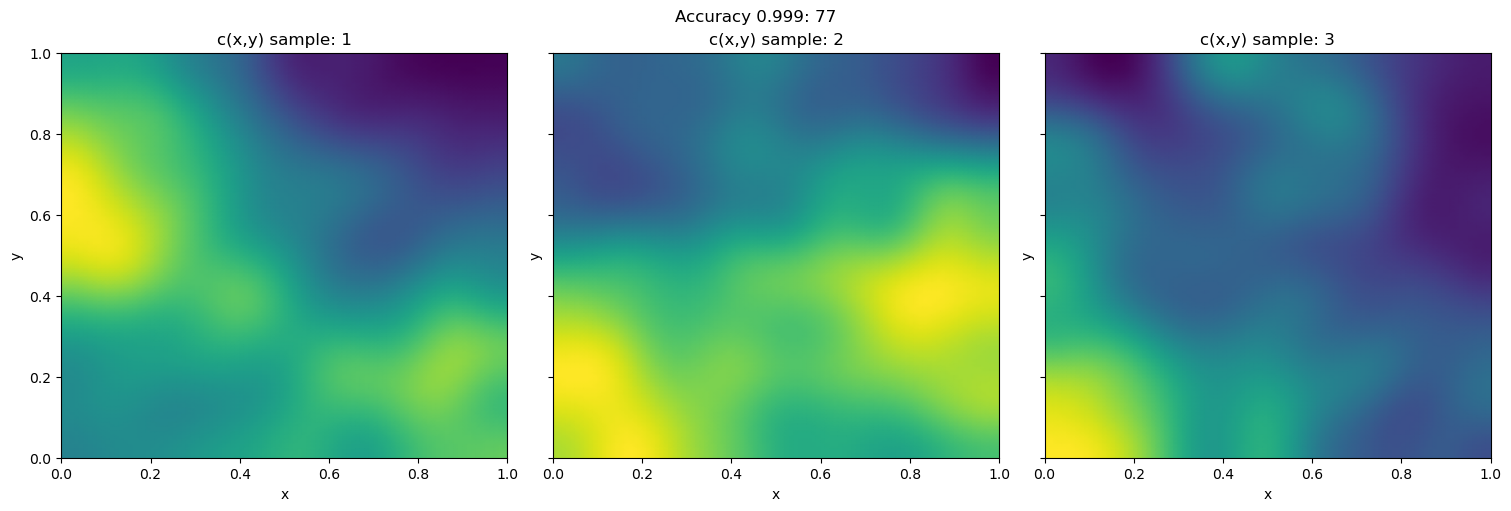

In [10]:
en_f= 1 - np.cumsum(Si)/np.sum(Si)

plt.plot(1-en_f)
plt.xlabel("# Singular Value")
plt.ylabel("1-Accuracy")

for ac in [0.98,0.99,0.999]:
    S = np.copy(Si)
    r_f = np.argwhere(en_f<(1-ac))[0,0]
    #r_f = min(r_f, 512)

    S[r_f:] = np.zeros_like(S[r_f:])
    s = np.concatenate([np.diag(S), np.zeros((Ui.shape[0]-S.shape[0], S.shape[0]))], axis=0)

    samples_ = Ui @s@Vi

    samples_ = samples_.reshape((101,101,M//2))

    _, axs = plt.subplots(1,3,figsize = (15,5), layout='constrained', sharey=True)
    plt.suptitle(f"Accuracy {ac}: {r_f}")
    for i in range(3):
        axs[i].pcolormesh(X, Y, samples_[:,:,i], shading="gouraud")
        axs[i].set_xlabel("x"), axs[i].set_ylabel("y"), axs[i].set_title(f"c(x,y) sample: {i+1}")

In [12]:
r_f = np.argwhere(en_f<(1-acc))[0,0]
    
r_f = min(r_f, 512)
print(r_f)

Uf = Ui[:,:r_f]
print(Uf.shape)

f_hat = np.matmul(Uf.T,train_inputs)
print(f_hat.shape)

x_train_part = f_hat.T.astype(np.float32)
print(x_train_part.shape)

11
(10201, 11)
(11, 500)
(500, 11)


In [13]:

Y, X = np.meshgrid(xgrid, xgrid)


X_upper = np.reshape(X, -1)
Y_upper = np.reshape(Y, -1)
N_upper = len(X_upper)
x_train = np.zeros((M//2 * N_upper, r_f + 2), dtype = np.float32)
y_train = np.zeros(M//2 * N_upper, dtype = np.float32)



for i in range(M//2):
    d_range = range(i*N_upper, (i + 1)*N_upper)
    x_train[d_range , 0:r_f]   = x_train_part[i, :]
    x_train[d_range , r_f]     = X_upper
    x_train[d_range , r_f + 1] = Y_upper 
    y_train[d_range] = np.reshape(outputs[:, :, i], -1)

In [20]:
d_range = range(0, N_upper)

x_train[d_range,0:2]

array([[-2020.0035  ,    -7.389076],
       [-2020.0035  ,    -7.389076],
       [-2020.0035  ,    -7.389076],
       ...,
       [-2020.0035  ,    -7.389076],
       [-2020.0035  ,    -7.389076],
       [-2020.0035  ,    -7.389076]], dtype=float32)

In [18]:
x_train_part[0, :]

array([-2.0200035e+03, -7.3890762e+00, -4.1786733e+00,  8.7324162e+00,
        6.6067874e-01, -3.7205606e+00,  3.3425260e+00, -1.2471797e+00,
        4.9929655e-01, -4.2144828e-02, -1.7705023e-01], dtype=float32)